In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.cross_decomposition import PLSRegression, CCA, PLSSVD, PLSCanonical
import warnings
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from MVA_algo import ReducedRankRegressor
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt

from tueplots import bundles

bundles.icml2022()
{'text.usetex': True, 'font.family': 'serif', 'text.latex.preamble': '\\usepackage{times} ', 'figure.figsize': (3.25, 2.0086104634371584), 'figure.constrained_layout.use': True, 'figure.autolayout': False, 'savefig.bbox': 'tight', 'savefig.pad_inches': 0.015, 'font.size': 8, 'axes.labelsize': 8, 'legend.fontsize': 6, 'xtick.labelsize': 6, 'ytick.labelsize': 6, 'axes.titlesize': 8}

bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)
{'text.usetex': False, 'font.serif': ['Times'], 'mathtext.fontset': 'stix', 'mathtext.rm': 'Times', 'mathtext.it': 'Times:italic', 'mathtext.bf': 'Times:bold', 'font.family': 'sans-serif', 'figure.figsize': (6.75, 8.343458848123582), 'figure.constrained_layout.use': True, 'figure.autolayout': False, 'savefig.bbox': 'tight', 'savefig.pad_inches': 0.015, 'font.size': 8, 'axes.labelsize': 8, 'legend.fontsize': 6, 'xtick.labelsize': 6, 'ytick.labelsize': 6, 'axes.titlesize': 8}


# Plug any of those into either the rcParams or into an rc_context:

plt.rcParams.update(bundles.icml2022())

In [3]:
import scienceplots
plt.style.use(['no-latex'])

In [4]:
import matplotlib.colors as mcolors
cmap = plt.cm.get_cmap('coolwarm')
blue_rgba1 = cmap(0.1)
blue_rgba2 = cmap(0.25)
red_rgba2 = cmap(0.75)
red_rgba1 = cmap(0.9)

/tmp/ipykernel_1469/477476976.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


In [5]:
def gen_rr(d, p, rank, coef):
    A = np.random.uniform(coef, coef+2, (d, rank))
    B = np.random.uniform(coef, coef+2, (rank, p))
    C = A @ B
    return C/np.sum(C)

def gen_data(n=10, d=500, p=500, r=1, l=1, rank=20, coef=1, intervention=2) :
    A_train = np.random.normal(0, 1, size=(n, l))
    A_test = np.random.normal(0, intervention, size=(n, l))

    N_A_train, N_X_train, N_Y_train, N_H_train =  np.random.normal(0, 1, (n, r)), np.random.normal(0, 1, (n, d)), np.random.normal(0, 1, (n, p)), np.random.normal(0, 1, (n, l))
    N_A_test, N_X_test, N_Y_test, N_H_test =  np.random.normal(0, 1, (n, r)), np.random.normal(0, 1, (n, d)), np.random.normal(0, 1, (n, p)), np.random.normal(0, 1, (n, l))
    
    # Regression weights sampling (as a reduced rank weight matrix)
    B_XY = gen_rr(d=d, p=p, rank=rank, coef=coef)
    
    # training data
    H_train = N_H_train
    X_train = 0.5*A_train + H_train + N_X_train
    Y_train = 2*A_train + X_train @ B_XY + H_train + N_Y_train
    
    # Testing data
    H_test = N_H_test
    X_test = 0.5*A_test + H_test + N_X_test
    Y_test = 2*A_test + X_test @ B_XY + H_test + N_Y_test
    
    # Scaling 
    sc_A, sc_X, sc_Y = StandardScaler(), StandardScaler(), StandardScaler()
    A_train, X_train, Y_train, N_Y_train = sc_A.fit_transform(A_train), sc_X.fit_transform(X_train), sc_Y.fit_transform(Y_train), sc_Y.transform(N_Y_train)
    A_test, X_test, Y_test, N_Y_test = sc_A.transform(A_test), sc_X.transform(X_test), sc_Y.transform(Y_test), sc_Y.transform(N_Y_test)
    
    return A_train, X_train, Y_train, A_test, X_test, Y_test, B_XY, N_Y_train, N_Y_test


class AnchorOptimalProjection:
    def __init__(self,gamma=5):
        self.gamma = gamma
        
    def fit(self, A):
        P_A = A @ np.linalg.inv(A.T @ A) @ A.T
        if self.gamma == 'IV':
             self.AOP = P_A
        else :
            n = A.shape[0]
            self.AOP = np.identity(n) + (np.sqrt(self.gamma) - 1)*P_A
        
    def transform(self, X, Y=None):
        if Y is None:
            return self.AOP @ X
        else :
            return self.AOP @ X, self.AOP @ Y
    
    def fit_transform(self, A, X, Y=None):
        self.fit(A)
        return self.transform(X, Y)
    
    
def scores(A, Y, Y_pred) :
    res = Y - Y_pred
    mse = ((res)**2).mean()
    mean_corr = np.abs(np.corrcoef(np.hstack((A, res)).T)[0,1:]).mean()
    return mse, mean_corr


In [6]:
# Setting the parameters for gamma and alpha values
n_gamma, n_alpha = 10, 20

# Creating arrays for gamma values
gammas = np.logspace(0, 4, n_gamma)

# Creating an array for ranks
ranks = np.arange(10, 31, 5)
n_rank = ranks.shape[0]

# Creating an array for alpha values
alphas = np.logspace(0, 8, n_alpha)

# Initializing arrays to store validation and test Mean Squared Error (MSE) and Mean Correlation scores
MSEs_val, MEAN_CORRs_val = np.zeros((n_gamma, n_alpha, n_rank)), np.zeros((n_gamma, n_alpha, n_rank))
MSEs_test, MEAN_CORRs_test = np.zeros((n_gamma, n_alpha, n_rank)), np.zeros((n_gamma, n_alpha, n_rank))

B=10
# Looping through gamma, alpha, and rank values
for b in tqdm(range(B)):
    # Generate data
    rank = np.random.randint(10, 30)
    A_train_full, X_train_full, Y_train_full, A_test, X_test, Y_test, B_XY, N_Y_train, N_Y_test = gen_data(n=300, d=120, p=120, r=1, l=1, rank=rank, coef=1, intervention=2)
    A_train, A_val, X_train, X_val, Y_train, Y_val = train_test_split(A_train_full, X_train_full, Y_train_full, test_size=0.5)
    for i in range(n_gamma):
        for j in range(n_alpha):
            for k in range(n_rank):
                # Extracting current gamma, alpha, and rank
                gamma, alpha, rank = gammas[i], alphas[j], ranks[k]

                # Training anchor-regularized model
                model = ReducedRankRegressor(rank=rank, reg=alpha)
                AOP = AnchorOptimalProjection(gamma=gamma)
                X_train_transform, Y_train_transform = AOP.fit_transform(A_train, X_train, Y_train)
                model.fit(X_train_transform, Y_train_transform)

                # Making predictions
                Y_pred_val = model.predict(X_val)
                Y_pred_test = model.predict(X_test)

                # Computing scores
                mse_val, mean_corr_val = scores(A_train, Y_val, Y_pred_val)
                mse_test, mean_corr_test = scores(A_test, Y_test, Y_pred_test)

                # Storing results
                MSEs_val[i, j, k]+= mse_val/B
                MEAN_CORRs_val[i, j, k] = mean_corr_val/B
                MSEs_test[i, j, k]+= mse_test/B
                MEAN_CORRs_test[i, j, k] += mean_corr_test/B


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:43<00:00, 16.30s/it]


In [7]:
metric = 0.1*MSEs_val/MSEs_val.sum() + 0.9*MEAN_CORRs_val/MEAN_CORRs_val.sum()

In [8]:
optimal_params = np.unravel_index(metric.argmin(), metric.shape)
optimal_params_rrrr = np.unravel_index(MSEs_val[n_gamma//2-1,:,:].argmin(), MSEs_val[n_gamma//2-1,:,:].shape)

In [9]:
gammas[optimal_params[0]], alphas[optimal_params[1]], ranks[optimal_params[2]]

(10000.0, 127.42749857031335, 25)

/tmp/ipykernel_1469/766048984.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0].scatter(MSEs_val[optimal_params], MEAN_CORRs_val[optimal_params], c=blue_rgba1, marker="D", label='Anchor 0.9/0.1', s=800, edgecolors='black', zorder=1)  # Increased marker size, added edgecolor, modified color
/tmp/ipykernel_1469/766048984.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0].scatter(MSEs_val[n_gamma // 2 - 1, :, :

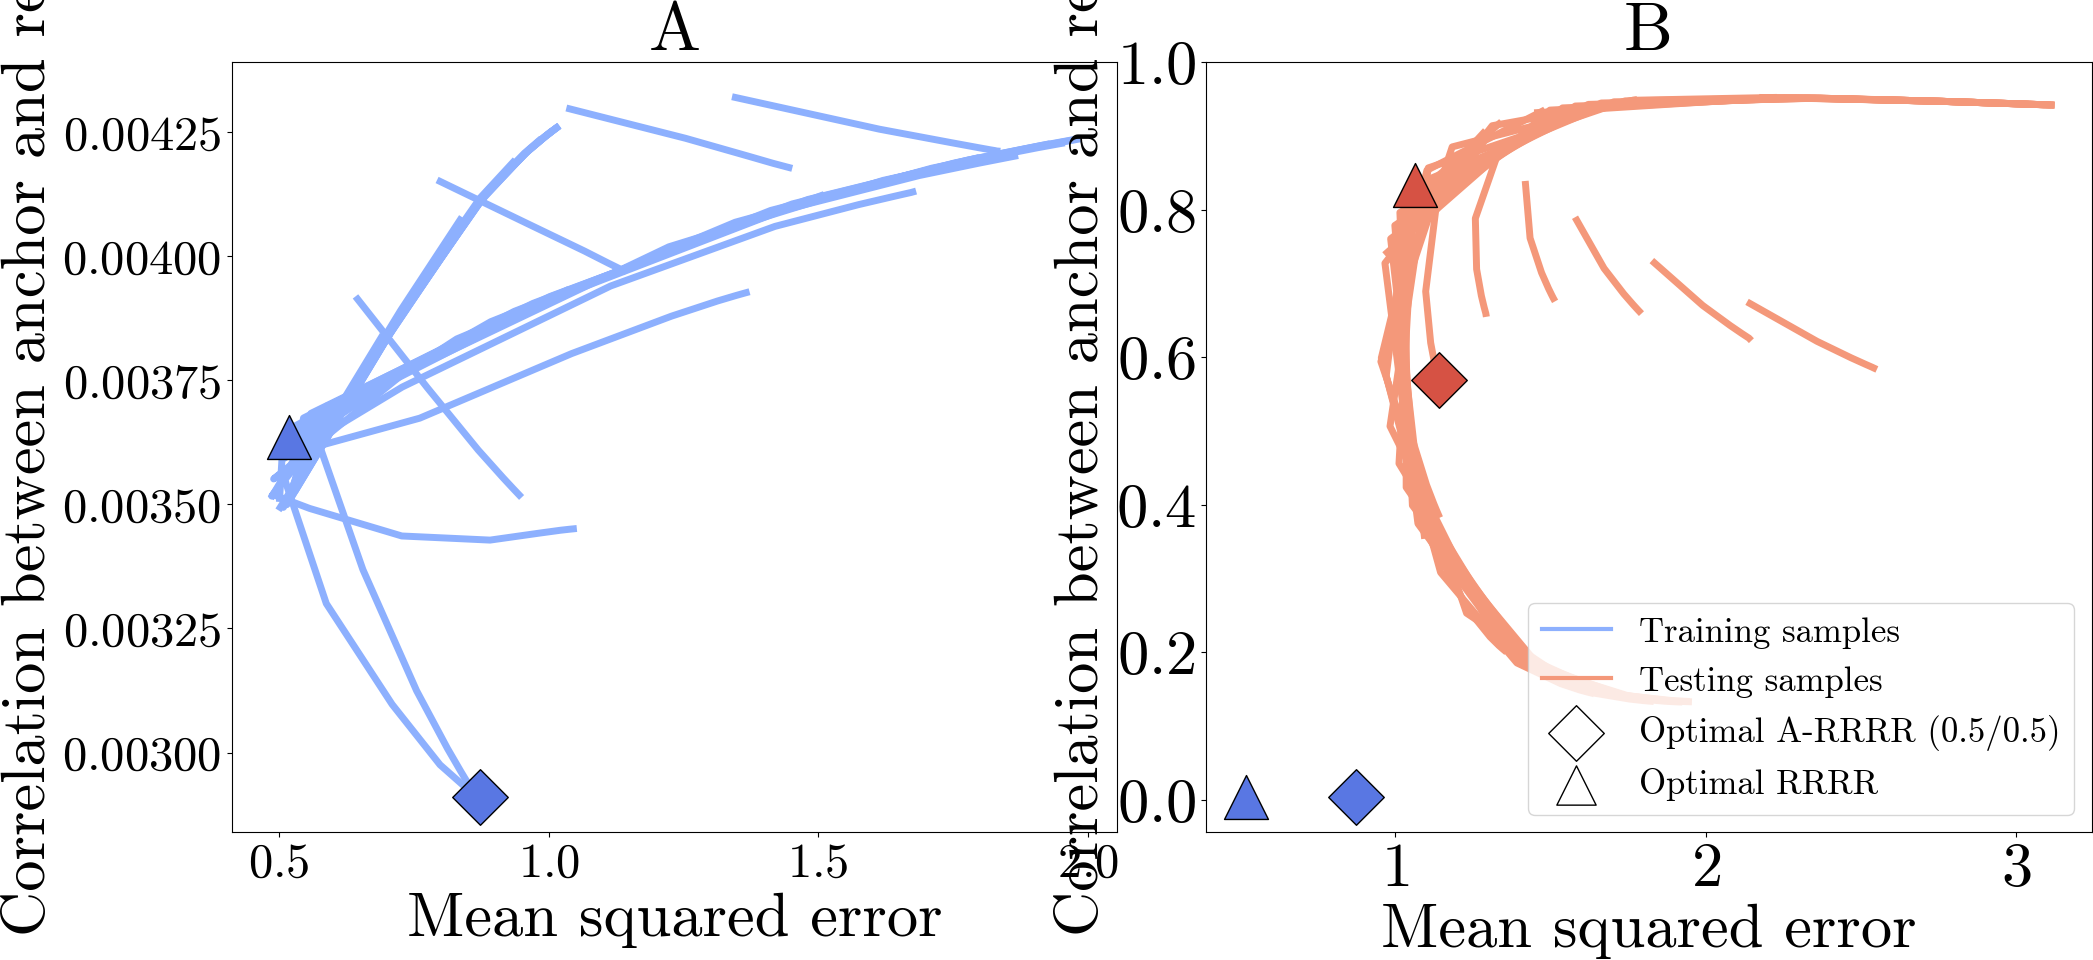

In [10]:
import matplotlib.pyplot as plt

# Create a figure with subplots and add space between the plots
fig, axs = plt.subplots(1, 2, figsize=(24, 10), gridspec_kw={'wspace': 0.1})  # Increased figure size and added space between plots

# Plotting training data in the first subplot
axs[0].plot(MSEs_val[:,:,:].min(axis=2), MEAN_CORRs_val[:,:,:].min(axis=2), c=blue_rgba2, linestyle='-', linewidth=5, zorder=-1)  # Increased linewidth, modified color
axs[0].scatter(MSEs_val[optimal_params], MEAN_CORRs_val[optimal_params], c=blue_rgba1, marker="D", label='Anchor 0.9/0.1', s=800, edgecolors='black', zorder=1)  # Increased marker size, added edgecolor, modified color
axs[0].scatter(MSEs_val[n_gamma // 2 - 1, :, :][optimal_params_rrrr], MEAN_CORRs_val[n_gamma // 2 - 1, :, :][optimal_params_rrrr], c=blue_rgba1, marker="^", label='RRRR', s=1000, edgecolors='black', zorder=1)  # Increased marker size, added edgecolor, modified color
axs[0].set_xlabel('Mean squared error', fontsize=45)  # Increased font size
axs[0].set_ylabel('Correlation between anchor and res', fontsize=45)  # Increased font size
axs[0].tick_params(axis='both', which='major', labelsize=45)  # Increased tick font size
axs[0].set_title('A', fontsize=50)  # Increased font size

# Plotting both training and testing data in the second subplot
axs[1].plot([],[], c=blue_rgba2, linestyle='-', linewidth=3, label='Training samples')  # Increased linewidth, modified color
axs[1].plot([],[], c=red_rgba2, linestyle='-', linewidth=3, label='Testing samples')  # Increased linewidth, modified color
axs[1].scatter(MSEs_val[optimal_params], MEAN_CORRs_val[optimal_params], c=blue_rgba1, marker="D", s=800, edgecolors='black', zorder=1)  # Increased marker size, added edgecolor, modified color
axs[1].scatter(MSEs_val[n_gamma // 2 - 1, :, :][optimal_params_rrrr], MEAN_CORRs_val[n_gamma // 2 - 1, :, :][optimal_params_rrrr], c=blue_rgba1, marker="^", s=1000, edgecolors='black', zorder=1)  # Increased marker size, added edgecolor, modified color
axs[1].plot(MSEs_test[:,:,:].min(axis=2), MEAN_CORRs_test[:,:,:].min(axis=2), c=red_rgba2, linestyle='-', linewidth=5, zorder=-1)  # Increased linewidth, modified color
axs[1].scatter(MSEs_test[optimal_params], MEAN_CORRs_test[optimal_params], c=red_rgba1, marker="D", s=800, edgecolors='black', zorder=1)  # Increased marker size, added edgecolor, modified color
axs[1].scatter(MSEs_test[n_gamma // 2 - 1, :, :][optimal_params_rrrr], MEAN_CORRs_test[n_gamma // 2 - 1, :, :][optimal_params_rrrr], c=red_rgba1, marker="^", s=1000, edgecolors='black', zorder=1)  # Increased marker size, added edgecolor, modified color

# Add diamond shape with text "Anchor 0.9/0.1"
axs[1].scatter([], [], marker="D", color='white', edgecolors='black', label='Optimal A-RRRR (0.5/0.5)', s=800)  # Increased marker size
# Add triangle shape with text "RRRR"
axs[1].scatter([], [], marker="^", color='white', edgecolors='black', label='Optimal RRRR', s=800)  # Increased marker size

# Move legend to the right of the second plot
axs[1].legend(loc='lower right', fontsize=25)  # Increased legend font size

axs[1].set_xlabel('Mean squared error', fontsize=45)  # Increased font size
axs[1].set_ylabel('Correlation between anchor and res', fontsize=45)  # Increased font size
axs[1].tick_params(axis='both', which='major', labelsize=45)  # Increased tick font size
axs[1].set_title('B', fontsize=50)  # Increased font size

# Set font sizes for ticks
axs[0].tick_params(axis='both', which='major', labelsize=35)  # Increased tick font size

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()
